# 0) Modules & Functions

In [127]:
import os
import pandas as pd
from rdkit import Chem
import subprocess
import hashlib
import tempfile
import base64
import numpy as np
from itertools import combinations
from scipy.stats import pearsonr
from tqdm import tqdm
import time
from collections import defaultdict
from rdkit.Chem import AllChem
from rdkit import RDLogger
import warnings
import re
from rdkit.Chem import inchi
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from rdkit.Chem import Descriptors

# Disable RDKit warnings
RDLogger.DisableLog('rdApp.*')

warnings.filterwarnings("ignore", category=UserWarning, module="rdkit")
warnings.filterwarnings("ignore", category=FutureWarning, module="rdkit")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="rdkit")

class MMPGenerator:
    def __init__(self, df_input, output_csv, mmpa_dir='../mmpa',
                 symmetric=True, max_heavy=14, max_ratio=0.7, verbose=True):
        self.df_original = df_input.copy()
        self.output_csv = output_csv
        self.mmpa_dir = mmpa_dir
        self.symmetric = symmetric
        self.max_heavy = max_heavy
        self.max_ratio = max_ratio
        self.verbose = verbose

    def _get_inchikey(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.inchi.MolToInchiKey(mol)
        return self.encode_string(smiles)

    def encode_string(self, s):
        return base64.urlsafe_b64encode(s.encode()).decode()

    def decode_string(self, b64):
        return base64.urlsafe_b64decode(b64.encode()).decode()

    def run(self):
        self.df_original['ID'] = [self._get_inchikey(smi) for smi in self.df_original['SMILES']]
        y_map = self.df_original.set_index('ID')['Y'].to_dict()

        with tempfile.TemporaryDirectory() as tmp:
            smi_path = os.path.join(tmp, 'input.smi')
            frag_path = os.path.join(tmp, 'fragmented.txt')
            mmps_path = os.path.join(tmp, 'mmps.csv')
            smirks_path = os.path.join(tmp, 'smirks.txt')
            cansmirks_path = os.path.join(tmp, 'cansmirks.txt')

            self.df_original[['SMILES', 'ID']].to_csv(smi_path, index=False, sep=' ', header=False)

            print("0) Fragments generation")
            with open(frag_path, 'w') as out:
                subprocess.run(['python', f'{self.mmpa_dir}/rfrag.py'], stdin=open(smi_path), stdout=out)

            print("1) Indexing")
            cmd = ['python', f'{self.mmpa_dir}/indexing.py']
            if self.symmetric:
                cmd.append('-s')
            if self.max_heavy:
                cmd.extend(['-m', str(self.max_heavy)])
            if self.max_ratio:
                cmd.extend(['-r', str(self.max_ratio)])

            with open(mmps_path, 'w') as out:
                subprocess.run(cmd, stdin=open(frag_path), stdout=out)

            with open(mmps_path) as f:
                lines = [line.strip() for line in f if line.strip()]


            splits = [line.split(',') for line in lines]
            max_len = max(len(s) for s in splits)

            df = pd.DataFrame(splits, columns=['L_SMILES', 'R_SMILES', 'L_ID', 'R_ID', 'SMIRKS', 'CORE'])


            df['L_Y'] = df['L_ID'].map(y_map)
            df['R_Y'] = df['R_ID'].map(y_map)
            df['Delta_Y'] = df['R_Y'] - df['L_Y']

            df = df[df['SMIRKS'].apply(lambda x: isinstance(x, str) and '>>' in x)]

            df['__row'] = range(len(df))
            df[['SMIRKS', '__row']].to_csv(smirks_path, index=False, sep=' ', header=False)

            print("2) Canonical SMIRKS generation")
            with open(cansmirks_path, 'w') as out:
                subprocess.run(['python', f'{self.mmpa_dir}/cansmirk.py'], stdin=open(smirks_path), stdout=out)


            canon_df = pd.read_csv(cansmirks_path, sep=' ', names=['Canonical_SMIRKS', 'index'])


            df = df.merge(canon_df, left_on='__row', right_on='index').drop(columns=['__row', 'index'])

            df[['L_sub', 'R_sub']] = df['Canonical_SMIRKS'].str.split('>>', expand=True)


            df['L_sub_ID'] = [self.encode_string(k) for k in df['L_sub'].tolist()]
            df['R_sub_ID'] = [self.encode_string(k) for k in df['R_sub'].tolist()]
            df['SMIRKS_ID'] = [self.encode_string(k) for k in df['Canonical_SMIRKS'].tolist()]
            df['CORE_ID'] = [self.encode_string(k) for k in df['CORE'].tolist()]
            df = df.drop_duplicates()


            df[['L_SMILES', 'R_SMILES', 'L_ID', 'R_ID', 'SMIRKS', 'CORE', 'L_Y', 'R_Y', 'Delta_Y', 'L_sub', 'R_sub', 'L_sub_ID', 'R_sub_ID', 'SMIRKS_ID', 'CORE_ID']].to_csv(
                self.output_csv, index=False
            )


class MMPAugmentorFixed:
    def __init__(self, df, min_common=4, pearson_thresh=0.3, crmsd_thresh=0.4):
        self.df = df.copy()
        self.min_common = min_common
        self.pearson_thresh = pearson_thresh
        self.crmsd_thresh = crmsd_thresh
        self.series = {}
        self.pair_scores = []
        self.filtered_pairs = []
        self.augmented_data = []

    def _extract_series(self):
        start = time.time()
        self.series = {
            core: group for core, group in self.df.groupby("CORE")
        }

    def _compute_pairwise_scores(self):
        start = time.time()
        self.pair_scores = []
        series_items = list(self.series.items())
        total_combinations = len(series_items) * (len(series_items) - 1) // 2
        for (core1, df1), (core2, df2) in tqdm(combinations(series_items, 2), desc="3) Computing pairwise correlations", total=total_combinations):
            subs1 = set(df1["L_sub"])
            subs2 = set(df2["L_sub"])
            common = subs1 & subs2
            if len(common) < self.min_common:
                continue

            merged = pd.merge(
                df1, df2,
                left_on=["L_sub", "R_sub"],
                right_on=["L_sub", "R_sub"],
                suffixes=('_1', '_2')
            )
            if len(merged) < self.min_common:
                continue

            y1 = merged['Delta_Y_1'].values
            y2 = merged['Delta_Y_2'].values
            crmsd = np.sqrt(np.mean((y1 - y2) ** 2))
            try:
                corr = pearsonr(y1, y2)[0]
            except:
                corr = np.nan

            self.pair_scores.append((core1, core2, crmsd, corr, len(merged)))

    def _filter_pairs(self):
        start = time.time()
        self.filtered_pairs = [
            (s1, s2) for s1, s2, rmsd, corr, n in self.pair_scores
            if rmsd <= self.crmsd_thresh and (not np.isnan(corr) and corr >= self.pearson_thresh)
        ]

    def _augment(self):
        start = time.time()
        augmented_entries = []

        for s1, s2 in tqdm(self.filtered_pairs, desc="4) Augmenting data"):
            df1 = self.series[s1]
            df2 = self.series[s2]

            tf1 = df1[["L_sub", "R_sub", "Delta_Y"]].to_dict("records")
            tf2 = df2[["L_sub", "R_sub", "Delta_Y"]].to_dict("records")

            df1_dict = defaultdict(list)
            for _, row in df1.iterrows():
                df1_dict[row["L_sub"]].append(row.to_dict())

            df2_dict = defaultdict(list)
            for _, row in df2.iterrows():
                df2_dict[row["L_sub"]].append(row.to_dict())

            for entry in tf1:
                l_sub = entry["L_sub"]
                for base in df2_dict.get(l_sub, []):
                    r_sub = entry["R_sub"]
                    delta = entry["Delta_Y"]
                    new_y = base["L_Y"] + delta
                    smirks_new = l_sub + ">>" + r_sub
                    augmented_entries.append({
                        "CORE": s1,
                        "L_sub": l_sub,
                        "R_sub": r_sub,
                        "L_Y": base["L_Y"],
                        "R_Y": new_y,
                        "Delta_Y": delta,
                        "AUG": True,
                        "L_SMILES": base.get("L_SMILES"),
                        "L_ID": base.get("L_ID"),
                        "L_sub_ID": base.get("L_sub_ID"),
                        "R_sub_ID": base64.urlsafe_b64encode(r_sub.encode()).decode(),
                        "SMIRKS": smirks_new,
                        "SMIRKS_ID": base64.urlsafe_b64encode(smirks_new.encode()).decode(),
                        "CORE_ID": base64.urlsafe_b64encode(s1.encode()).decode()
                    })

            for entry in tf2:
                l_sub = entry["L_sub"]
                for base in df1_dict.get(l_sub, []):
                    r_sub = entry["R_sub"]
                    delta = entry["Delta_Y"]
                    new_y = base["L_Y"] + delta
                    smirks_new = l_sub + ">>" + r_sub
                    augmented_entries.append({
                        "CORE": s2,
                        "L_sub": l_sub,
                        "R_sub": r_sub,
                        "L_Y": base["L_Y"],
                        "R_Y": new_y,
                        "Delta_Y": delta,
                        "AUG": True,
                        "L_SMILES": base.get("L_SMILES"),
                        "L_ID": base.get("L_ID"),
                        "L_sub_ID": base.get("L_sub_ID"),
                        "R_sub_ID": base64.urlsafe_b64encode(r_sub.encode()).decode(),
                        "SMIRKS": smirks_new,
                        "SMIRKS_ID": base64.urlsafe_b64encode(smirks_new.encode()).decode(),
                        "CORE_ID": base64.urlsafe_b64encode(s2.encode()).decode()
                    })

        self.augmented_data = pd.DataFrame(augmented_entries)


    def run(self):
        self._extract_series()
        self._compute_pairwise_scores()
        self._filter_pairs()
        self._augment()

        original = self.df.copy()
        original["AUG"] = False
        return pd.concat([original, self.augmented_data], ignore_index=True)
    
    def get_pair_scores_df(self):
        """
        Return a DataFrame of scaffold pair scores (cRMSD, Pearson, common MMP count)
        """
        return pd.DataFrame(
            self.pair_scores,
            columns=["Scaffold_1", "Scaffold_2", "cRMSD", "Pearson", "N_common"]
        )

    def get_augmented_only(self):
        """
        Return only the augmented (predicted) entries.
        """
        return self.augmented_data.copy()
    

def analyze_scaffold_pair_scores(df):
    summary = {
        "Total Pairs": len(df),
        "Mean cRMSD": df["cRMSD"].mean(),
        "Median cRMSD": df["cRMSD"].median(),
        "Std cRMSD": df["cRMSD"].std(),
        "Mean Pearson": df["Pearson"].mean(),
        "Median Pearson": df["Pearson"].median(),
        "Std Pearson": df["Pearson"].std(),
        "Mean N_common": df["N_common"].mean(),
        "Median N_common": df["N_common"].median()
    }

    high_corr = df["Pearson"] > 0.7
    low_crmsd = df["cRMSD"] < 0.5
    enough_common = df["N_common"] >= 5
    strong_pairs = df[high_corr & low_crmsd & enough_common]

    summary.update({
        "High Pearson (>0.7)": high_corr.sum(),
        "Low cRMSD (<0.5)": low_crmsd.sum(),
        "N_common ≥ 5": enough_common.sum(),
        "Strong Pairs (all 3)": len(strong_pairs)
    })

    top_corr = df.sort_values("Pearson", ascending=False).head(5)
    top_low_crmsd = df.sort_values("cRMSD").head(5)
    top_common = df.sort_values("N_common", ascending=False).head(5)

    return {
        "summary": summary,
        "top_corr": top_corr,
        "top_low_crmsd": top_low_crmsd,
        "top_common": top_common,
        "strong_pairs": strong_pairs
    }




def fast_apply_transformation(transformation, l_smiles, rxn_cache, core_cache, heavy_cache, core_smarts, failure_tracker=None):
    if pd.isna(transformation) or pd.isna(l_smiles):
        return None

    # --- Cache reaction and Δheavy ---
    if transformation not in rxn_cache:
        try:
            rxn = AllChem.ReactionFromSmarts(transformation)
            left_smi, right_smi = transformation.split(">>")
            left_mol = Chem.MolFromSmarts(left_smi)
            right_mol = Chem.MolFromSmarts(right_smi)
            delta_heavy = right_mol.GetNumHeavyAtoms() - left_mol.GetNumHeavyAtoms()
            rxn_cache[transformation] = (rxn, delta_heavy)
        except:
            return None
    else:
        rxn, delta_heavy = rxn_cache[transformation]

    # --- Cache L_SMILES heavy atom count ---
    if l_smiles not in heavy_cache:
        mol_l = Chem.MolFromSmiles(l_smiles)
        if mol_l is None:
            return None
        n_heavy_l = mol_l.GetNumHeavyAtoms()
        heavy_cache[l_smiles] = (mol_l, n_heavy_l)
    else:
        mol_l, n_heavy_l = heavy_cache[l_smiles]

    # --- Cache core mol ---
    if core_smarts not in core_cache:
        core_mol = Chem.MolFromSmarts(core_smarts)
        if core_mol is None:
            return None
        core_cache[core_smarts] = core_mol
    else:
        core_mol = core_cache[core_smarts]

    # --- Run reaction ---
    try:
        products = rxn.RunReactants((mol_l,))
    except Exception:
        return None

    if failure_tracker is not None:
        failure_tracker["total"] += 1
        if not products:
            failure_tracker["empty_prodsets"] += 1

    all_products = []
    for prod_set in products:
        if not prod_set and failure_tracker is not None:
            failure_tracker["empty_prodsets"] += 1
        for prod in prod_set:
            if prod is None:
                continue
            try:
                if not prod.HasSubstructMatch(core_mol):
                    continue
            except:
                continue
            n_heavy_r = prod.GetNumHeavyAtoms()
            if n_heavy_r - n_heavy_l != delta_heavy:
                continue
            all_products.append(Chem.MolToSmiles(prod, isomericSmiles=True))

    return all_products if all_products else None

def update_predicted_rows(df):
    df = df.drop_duplicates()
    mask = df["AUG"] == True
    indices = df[mask].index

    rxn_cache = {}
    heavy_cache = {}
    core_cache = {}

    new_rows = []
    failure_tracker = {"total": 0, "empty_prodsets": 0}

    for idx in tqdm(indices, desc="5) Updating predicted rows"):
        row = df.loc[idx]
        l_smiles = row["L_SMILES"]
        smirks = row["SMIRKS"]
        core = row["CORE"]

        r_smiles_list = fast_apply_transformation(
            smirks, l_smiles, rxn_cache, core_cache, heavy_cache, core,
            failure_tracker=failure_tracker
        )

        if r_smiles_list:
            for r_smiles in r_smiles_list:
                mol = Chem.MolFromSmiles(r_smiles)
                if mol:
                    r_id = Chem.InchiToInchiKey(Chem.MolToInchi(mol))
                    new_row = row.copy()
                    new_row["R_SMILES"] = r_smiles
                    new_row["R_ID"] = r_id
                    new_rows.append(new_row)

    df_non_aug = df[~mask]
    df_aug_expanded = pd.DataFrame(new_rows)
    df_final = pd.concat([df_non_aug, df_aug_expanded], ignore_index=True)

    # Print failure rate
    total = failure_tracker["total"]
    failed = failure_tracker["empty_prodsets"]
    if total > 0:
        print(f"⚠️  Empty product sets in {failed} / {total} ({100 * failed / total:.2f}%) of transformations")

    return df_final








def prepare_and_plot_prediction_vs_experiment_complete_with_output(imputed_df, std_threshold=0.5):

    print("6) Preparing output file")

    l_df = imputed_df[["L_SMILES", "L_Y", "AUG"]]
    r_df = imputed_df[["R_SMILES", "R_Y", "AUG"]]
    l_df.columns = ["SMILES", "Y", "AUG"]
    r_df.columns = ["SMILES", "Y", "AUG"]
    clean_df = pd.concat([l_df, r_df])


    # Count total before
    total_before = len(clean_df)

    # Drop rows with missing or invalid SMILES
    clean_df = clean_df.dropna(subset=["SMILES"]).copy()
    clean_df = clean_df[clean_df["SMILES"].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

    # Count total after
    total_after = len(clean_df)

    # Print failure rate
    fail_pct = 100 * (total_before - total_after) / total_before
    print(f"Invalid SMILES removed: {total_before - total_after} / {total_before} ({fail_pct:.2f}%)")

    tqdm.pandas(desc="7) Standardizing SMILES")
    clean_df["SMILES"] = clean_df["SMILES"].progress_apply(
        lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=True)
    )

    # Step 8) InChIKey generation
    tqdm.pandas(desc="8) Generating InChIKeys")
    clean_df['InChIKey'] = clean_df["SMILES"].progress_apply(smiles_to_inchikey)


    # Insert InChIKey as first column
    cols = ['InChIKey'] + [col for col in clean_df.columns if col != 'InChIKey']
    clean_df = clean_df[cols]


    clean_df_exp = clean_df[clean_df["AUG"] != True].copy()
    clean_df_pred = clean_df[clean_df["AUG"] == True].copy()

    # Normalize column names
    clean_df_exp = clean_df_exp.rename(columns={"R_SMILES": "SMILES", "R_Y": "Y"})
    clean_df_pred = clean_df_pred.rename(columns={"R_SMILES": "SMILES", "R_Y": "Y"})

    # Compute median and std per SMILES in predicted
    grouped_pred = clean_df_pred.groupby("InChIKey")["Y"].agg(["median", "std"]).reset_index()
    grouped_pred.columns = ["InChIKey", "Y", "STD"]
    grouped_pred["AUG"] = True

    # Re-add SMILES by mapping InChIKey → first SMILES in original pred dataframe
    inchikey_to_smiles = clean_df_pred.dropna(subset=["SMILES"]).drop_duplicates("InChIKey").set_index("InChIKey")["SMILES"].to_dict()
    grouped_pred["SMILES"] = grouped_pred["InChIKey"].map(inchikey_to_smiles)
    grouped_pred = grouped_pred[["InChIKey", "SMILES", "Y", "STD", "AUG"]]
    grouped_pred = grouped_pred[grouped_pred["STD"]<= std_threshold]

    # Final prediction rows
    exp_out = clean_df_exp[['InChIKey', "SMILES", "Y"]].copy()
    exp_out["STD"] = None
    exp_out["AUG"] = False
    exp_out = exp_out[["InChIKey", "SMILES", "Y", "STD", "AUG"]]

    exp_out = exp_out.dropna(how='all')
    grouped_pred = grouped_pred.dropna(how='all')

    # Remove predicted entries with InChIKey already in experimental
    known_keys = set(exp_out['InChIKey'])
    grouped_pred = grouped_pred[~grouped_pred['InChIKey'].isin(known_keys)]


    output_df = pd.concat(
    [exp_out.drop_duplicates("InChIKey"), grouped_pred.drop_duplicates("InChIKey")],
    ignore_index=True
    )

    output_df = output_df[~((output_df['AUG'] == True) & (output_df['InChIKey'].isin(output_df.loc[output_df['AUG'] == False, 'InChIKey'])))]

    return output_df


# Compute InChIKey from SMILES
def smiles_to_inchikey(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    try:
        return inchi.MolToInchiKey(mol)
    except:
        return None
    

def assign_set_from_inchikey(output_df, reference_df, smiles_col="SMILES", inchikey_col="InChIKey", set_col="SET"):
    # Compute InChIKey for each SMILES in output_df
    output_df[inchikey_col] = output_df[smiles_col].apply(
        lambda smi: Chem.inchi.MolToInchiKey(Chem.MolFromSmiles(smi)) if Chem.MolFromSmiles(smi) else None
    )
    
    # Create lookup from reference_df
    inchikey_map = dict(zip(reference_df[inchikey_col], reference_df[set_col]))
    
    # Map SET
    output_df[set_col] = output_df[inchikey_col].map(inchikey_map)
    
    return output_df


def smiles_to_morgan(smiles, radius=3, n_bits=4096):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits)
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits))

def train_and_compare_models(output_df, random_state=29121997):
    print("🔬 Starting model training and comparison...")

    # --- Step 1: Compute Morgan fingerprints for all molecules ---
    tqdm.pandas(desc="Generating fingerprints")
    output_df_ML = output_df.copy()
    output_df_ML["FP"] = output_df_ML["SMILES"].progress_apply(smiles_to_morgan)

    # --- Step 2: Split into training and testing sets ---
    train_df = output_df_ML[(output_df_ML["SET"].isin(["A","B"])==True) & (output_df_ML["AUG"] == False)]
    aug_df = output_df_ML[output_df_ML["AUG"] == True]
    test_df = output_df_ML[output_df_ML["SET"].isin(["A","B"])==False]

    # --- Step 3: Format X and y ---
    def get_X_y(df):
        X = np.stack(df["FP"].values)
        y = df["Y"].values
        return X, y

    X_train_no_aug, y_train_no_aug = get_X_y(train_df)
    X_train_aug, y_train_aug = get_X_y(pd.concat([train_df, aug_df], ignore_index=True))
    X_test, y_test = get_X_y(test_df)

    # --- Step 4: Train models ---
    model_no_aug = RandomForestRegressor(n_estimators=200, random_state=random_state, n_jobs=-1)
    model_aug = RandomForestRegressor(n_estimators=200, random_state=random_state, n_jobs=-1)

    print("🚜 Training on raw train set (no AUG)...")
    model_no_aug.fit(X_train_no_aug, y_train_no_aug)

    print("🌱 Training on train + AUG data...")
    model_aug.fit(X_train_aug, y_train_aug)

    # --- Step 5: Predict on test set ---
    y_pred_no_aug = model_no_aug.predict(X_test)
    y_pred_aug = model_aug.predict(X_test)

    # --- Step 6: Compute metrics ---
    def report_metrics(y_true, y_pred, label):
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)
        print(f"{label} => RMSE: {rmse:.4f}, R²: {r2:.4f}")
        return rmse, r2

    print("\n📊 Evaluation on test set:")
    rmse_no_aug, r2_no_aug = report_metrics(y_test, y_pred_no_aug, "Baseline model (no AUG)")
    rmse_aug, r2_aug = report_metrics(y_test, y_pred_aug, "Augmented model (with AUG)")

    return {
        "RMSE_NoAug": rmse_no_aug,
        "R2_NoAug": r2_no_aug,
        "RMSE_Aug": rmse_aug,
        "R2_Aug": r2_aug,
        "N_Train_NoAug": len(X_train_no_aug),
        "N_Train_Aug": len(X_train_aug)
    }


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tqdm import tqdm

def train_and_compare_models_external(output_df, test_set, random_state=29121997):
    print("🔬 Starting model training on external test set...")

    # Compute Morgan fingerprints
    tqdm.pandas(desc="Generating fingerprints (train)")
    output_df = output_df.copy()
    output_df["FP"] = output_df["SMILES"].progress_apply(smiles_to_morgan)

    tqdm.pandas(desc="Generating fingerprints (test)")
    test_set = test_set.copy()
    test_set["FP"] = test_set["SMILES"].progress_apply(smiles_to_morgan)

    # Split training: augmented vs no-augmented
    train_df_noaug = output_df[output_df["AUG"] == False]
    train_df_aug = output_df  # full output_df includes AUG

    def get_X_y(df):
        X = np.stack(df["FP"].values)
        y = df["Y"].values
        return X, y

    X_train_noaug, y_train_noaug = get_X_y(train_df_noaug)
    X_train_aug, y_train_aug = get_X_y(train_df_aug)
    X_test, y_test = get_X_y(test_set)

    model_noaug = RandomForestRegressor(n_estimators=300, random_state=random_state, n_jobs=-1)
    model_aug = RandomForestRegressor(n_estimators=300, random_state=random_state, n_jobs=-1)

    print("🚜 Training on no-aug data...")
    model_noaug.fit(X_train_noaug, y_train_noaug)

    print("🌱 Training on full augmented data...")
    model_aug.fit(X_train_aug, y_train_aug)

    y_pred_noaug = model_noaug.predict(X_test)
    y_pred_aug = model_aug.predict(X_test)

    def report_metrics(y_true, y_pred, label):
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)
        print(f"{label} => RMSE: {rmse:.4f}, R²: {r2:.4f}")
        return rmse, r2

    print("\n📊 Evaluation on external test set:")
    rmse_noaug, r2_noaug = report_metrics(y_test, y_pred_noaug, "No AUG model")
    rmse_aug, r2_aug = report_metrics(y_test, y_pred_aug, "AUG model")

    return {
        "RMSE_NoAug": rmse_noaug,
        "R2_NoAug": r2_noaug,
        "RMSE_Aug": rmse_aug,
        "R2_Aug": r2_aug,
        "N_Train_NoAug": len(train_df_noaug),
        "N_Train_Aug": len(train_df_aug),
        "N_Test": len(test_set)
    }

from rdkit import Chem
from rdkit.Chem import Draw


def show_top_aug_vs_nonaug(output_df, n=8):
    # Sort by SMILES then AUG=False before AUG=True
    sorted_df = output_df.sort_values(by=["SMILES", "AUG"], ascending=[True, False])
    
    # Select top non-augmented and augmented
    top_nonaug = sorted_df[sorted_df["AUG"] == False].head(n)
    top_aug = sorted_df[sorted_df["AUG"] == True].head(n)

    combined = pd.concat([top_nonaug, top_aug])
    mols = [Chem.MolFromSmiles(s) for s in combined["SMILES"]]

    legends = [f'{i+1}. {row["InChIKey"][:8]} | {row["Y"]:.2f}' for i, row in combined.iterrows()]
    img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(400, 400), legends=legends, useSVG=False)
    return img


In [128]:
dataset = 'oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet'
df_full = pd.read_parquet(f'../data/exp/STL/{dataset}')
df_full

,InChIKey,SMILES,SET,Y
0,BMMZGWDGXPPDEW-UHFFFAOYSA-N,Fc1c[n]ccc1Nc1[n]c([n][n]2ccc(CNCCC[n]3c[n]cc3...,G,7.795880
1,DXLXRNZCYAYUED-UHFFFAOYSA-N,C(COc1ccc(cc1)-c1c[n]2[n]cc(c2[n]c1)-c1cc[n]c2...,C,4.801892
2,CYZIHLAVDIBJMV-UHFFFAOYSA-N,CC1(C)OC(=N)c2ccc(cc12)Nc1cc(cc[n]1)Oc1cc([n][...,D,6.180456
3,QINWZYFBTDNOCG-UHFFFAOYSA-N,N#Cc1c[n]c2ccc(c[n]12)-c1c([n]c[n]1CC1CCC1)-c1...,E,6.168770
4,XBZPZCSZHYZEBC-UHFFFAOYSA-N,CCc1cccc([n]1)-c1[n]c(CNc2cccc(c2)C#N)[nH]c1-c...,I,5.924453
...,...,...,...,...
1986,CKZSWAJXGWJYKE-UHFFFAOYSA-N,Cc1cc(c(F)cc1)-c1cc(Nc2cc[n]c3c[n][n](C)c23)c(...,I,7.397940
1987,INACEQVBTOQUCT-UHFFFAOYSA-N,Cc1cccc([n]1)-c1[n][n](CC(=O)Nc2cc(ccc2)C(N)=O...,F,6.124939
1988,OUGRNXPVTYJQNC-UHFFFAOYSA-N,C(c1ccccc1)[n]1cc(c([n]1)-c1cccc[n]1)-c1cc[n]c...,H,5.399027
1989,BSTPHJPQYISGIA-UHFFFAOYSA-N,Cc1cccc([n]1)-c1ccc(cc1-c1c[n]2c(cc1)[n]cc2C(N...,H,6.886057


# 1) Parameters

In [129]:
import os
import numpy as np
import pandas as pd
import optuna
from sklearn.metrics import r2_score, mean_squared_error

# Load dataset
dataset = 'oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet'
df_full = pd.read_parquet(f'../data/exp/STL/{dataset}')
df_full = df_full.sample(frac=1, random_state=42).reset_index(drop=True)

# Fold definition
set_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
optimization_results = []


# Objective for Optuna
def objective(trial):
    max_heavy = trial.suggest_int("max_heavy", 10, 20)
    max_ratio = trial.suggest_float("max_ratio", 0.1, 0.5)
    min_common = trial.suggest_int("min_common", 2, 5)
    pearson_thresh = trial.suggest_float("pearson_thresh", 0.1, 0.6)
    crmsd_thresh = trial.suggest_float("crmsd_thresh", 0.3, 3.0)
    std_threshold = trial.suggest_float("std_threshold", 0.3, 3.0)

    r2_scores = []
    aug_sizes = []
    noaug_sizes = []
    trial_metrics = []

    for test_set in set_list:
        df_train = df_full[df_full["SET"] != test_set]
        df_test = df_full[df_full["SET"] == test_set]

        if df_train.empty or df_test.empty:
            continue

        output_csv = f'temp_frag.csv'
        MMPGenerator(df_train, output_csv=output_csv, symmetric=True,
                     max_heavy=max_heavy, max_ratio=max_ratio, verbose=False).run()

        if not os.path.exists(output_csv):
            continue

        try:
            frag_df = pd.read_csv(output_csv, on_bad_lines="skip")
        except:
            continue
        if frag_df.empty:
            continue

        augmentor = MMPAugmentorFixed(frag_df, min_common=min_common,
                                      pearson_thresh=pearson_thresh,
                                      crmsd_thresh=crmsd_thresh)
        final_df3 = augmentor.run()
        imputed_df = update_predicted_rows(final_df3)
        clean_df = prepare_and_plot_prediction_vs_experiment_complete_with_output(imputed_df, std_threshold=std_threshold)
        output_df = assign_set_from_inchikey(clean_df, df_train)

        if output_df.empty:
            continue

        missing_rows = df_train[~df_train['InChIKey'].isin(output_df['InChIKey'])]
        missing_rows['STD'] = None
        missing_rows['AUG'] = False
        missing_rows = missing_rows[['InChIKey', 'SMILES', 'Y', 'STD', 'AUG', 'SET']]
        full_aug_df = pd.concat([output_df, missing_rows], ignore_index=True)

        metrics = train_and_compare_models_external(full_aug_df, df_test)
        r2_scores.append(metrics["R2_Aug"])
        aug_sizes.append(metrics["N_Train_Aug"])
        noaug_sizes.append(metrics["N_Train_NoAug"])
        trial_metrics.append(metrics)

    if not r2_scores:
        return -999.0

    result = {
        "params": trial.params,
        "r2_mean": np.mean(r2_scores),
        "r2_std": np.std(r2_scores),
        "size_aug_mean": np.mean(aug_sizes),
        "size_aug_std": np.std(aug_sizes),
        "size_noaug_mean": np.mean(noaug_sizes),
        "size_noaug_std": np.std(noaug_sizes),
        "all_fold_metrics": trial_metrics,
    }

    optimization_results.append(result)
    return result["r2_mean"]

# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Save results
df_summary = pd.DataFrame([{k: v for k, v in r.items() if k != "all_fold_metrics"} for r in optimization_results])
df_summary.to_csv("optuna_summary.csv", index=False)

# Save detailed metrics per trial
all_details = []
for i, res in enumerate(optimization_results):
    for fold_metric in res["all_fold_metrics"]:
        fold_metric.update({"trial": i})
        fold_metric.update(res["params"])
        all_details.append(fold_metric)

df_detailed = pd.DataFrame(all_details)
df_detailed.to_csv("optuna_all_fold_metrics.csv", index=False)

print(df_summary.sort_values("r2_mean", ascending=False))

[I 2025-04-22 12:26:55,300] A new study created in memory with name: no-name-f5916fb2-d9d0-4ff2-aac9-40c3c73cf9b0


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[12:27:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:27:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:27:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:27:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:27:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:27:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:27:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:27:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:27:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:27:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:27:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:27:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:27:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:27:27] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 35462 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 173022 (0.00%)


8) Generating InChIKeys: 100%|██████████| 173022/173022 [00:36<00:00, 4764.29it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 218/218 [00:00<00:00, 671.35it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6315, R²: 0.7193
AUG model => RMSE: 0.6222, R²: 0.7275


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[12:30:52] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:30:52] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:30:52] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:30:52] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:30:52] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:30:52] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:30:52] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:30:52] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:30:52] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:30:52] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:30:52] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:30:52] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:30:52] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:30:52] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 36238 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 174222 (0.00%)


8) Generating InChIKeys: 100%|██████████| 174222/174222 [00:34<00:00, 5077.56it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 202/202 [00:00<00:00, 695.58it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.7324, R²: 0.6323
AUG model => RMSE: 0.7473, R²: 0.6172


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[12:33:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:33:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:33:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:33:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:33:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:33:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:33:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:33:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:33:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:33:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:33:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:33:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:33:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:33:50] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 36243 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 176374 (0.00%)


8) Generating InChIKeys: 100%|██████████| 176374/176374 [00:35<00:00, 5007.83it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 199/199 [00:00<00:00, 716.70it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6306, R²: 0.7042
AUG model => RMSE: 0.6103, R²: 0.7229


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[12:36:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:36:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:36:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:36:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:36:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:36:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:36:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:36:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:36:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:36:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:36:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:36:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:36:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:36:59] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 41471 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 182084 (0.00%)


8) Generating InChIKeys: 100%|██████████| 182084/182084 [00:34<00:00, 5263.55it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 183/183 [00:00<00:00, 728.98it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6591, R²: 0.7409
AUG model => RMSE: 0.6658, R²: 0.7356


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[12:40:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:40:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:40:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:40:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:40:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:40:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:40:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:40:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:40:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:40:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:40:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:40:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:40:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:40:13] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 39661 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 181284 (0.00%)


8) Generating InChIKeys: 100%|██████████| 181284/181284 [00:40<00:00, 4478.42it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 188/188 [00:00<00:00, 684.33it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6406, R²: 0.7426
AUG model => RMSE: 0.6382, R²: 0.7445


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


5) Updating predicted rows: 100%|██████████| 39414/39414 [00:05<00:00, 7091.75it/s] 


⚠️  Empty product sets in 0 / 39414 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 172400 (0.00%)


8) Generating InChIKeys: 100%|██████████| 172400/172400 [00:34<00:00, 4933.24it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 206/206 [00:00<00:00, 650.48it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6358, R²: 0.7000
AUG model => RMSE: 0.6351, R²: 0.7007


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[12:46:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:46:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:46:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:46:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:46:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:46:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:46:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:46:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:46:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:46:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:46:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:46:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:46:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:46:44] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 37782 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 174956 (0.00%)


8) Generating InChIKeys: 100%|██████████| 174956/174956 [00:40<00:00, 4353.34it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 189/189 [00:00<00:00, 646.05it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.7436, R²: 0.6269
AUG model => RMSE: 0.7353, R²: 0.6352


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[12:50:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:50:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:50:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:50:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:50:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:50:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:50:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:50:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:50:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:50:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:50:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:50:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:50:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:50:24] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 37584 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 171748 (0.00%)


8) Generating InChIKeys: 100%|██████████| 171748/171748 [00:36<00:00, 4736.01it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 198/198 [00:00<00:00, 614.73it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.5786, R²: 0.7458
AUG model => RMSE: 0.5598, R²: 0.7621


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[12:53:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:53:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:53:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:53:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:53:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:53:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:53:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:53:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:53:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:53:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:53:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:53:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:53:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:53:49] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 36461 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 176152 (0.00%)


8) Generating InChIKeys: 100%|██████████| 176152/176152 [00:38<00:00, 4577.49it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 203/203 [00:00<00:00, 639.89it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6937, R²: 0.6221
AUG model => RMSE: 0.6972, R²: 0.6183


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[12:57:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:57:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:57:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:57:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:57:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:57:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:57:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:57:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:57:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:57:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:57:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:57:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:57:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:57:22] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 37046 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 170338 (0.00%)


8) Generating InChIKeys: 100%|██████████| 170338/170338 [00:36<00:00, 4720.60it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 205/205 [00:00<00:00, 614.86it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 13:00:17,463] Trial 0 finished with value: 0.6920966860246722 and parameters: {'max_heavy': 13, 'max_ratio': 0.20694136519761727, 'min_common': 4, 'pearson_thresh': 0.3281095702227851, 'crmsd_thresh': 1.7753759391778479, 'std_threshold': 2.0628054066439114}. Best is trial 0 with value: 0.6920966860246722.



📊 Evaluation on external test set:
No AUG model => RMSE: 0.7394, R²: 0.6388
AUG model => RMSE: 0.7206, R²: 0.6569
0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[13:00:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:00:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:00:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:00:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:00:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:00:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:00:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:00:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:00:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:00:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:00:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:00:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:00:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:00:48] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 18548 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 141002 (0.00%)


8) Generating InChIKeys: 100%|██████████| 141002/141002 [00:31<00:00, 4541.76it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 218/218 [00:00<00:00, 644.13it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6294, R²: 0.7212
AUG model => RMSE: 0.6372, R²: 0.7143


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[13:03:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:03:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:03:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:03:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:03:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:03:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:03:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:03:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:03:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:03:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:03:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:03:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:03:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:03:45] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 19445 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 143946 (0.00%)


8) Generating InChIKeys: 100%|██████████| 143946/143946 [00:31<00:00, 4546.51it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 202/202 [00:00<00:00, 604.17it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.7379, R²: 0.6267
AUG model => RMSE: 0.7489, R²: 0.6156


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[13:06:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:06:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:06:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:06:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:06:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:06:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:06:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:06:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:06:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:06:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:06:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:06:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:06:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:06:36] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 18903 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 143152 (0.00%)


8) Generating InChIKeys: 100%|██████████| 143152/143152 [00:30<00:00, 4672.83it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 199/199 [00:00<00:00, 655.20it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6293, R²: 0.7054
AUG model => RMSE: 0.6290, R²: 0.7056


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[13:09:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:09:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:09:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:09:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:09:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:09:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:09:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:09:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:09:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:09:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:09:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:09:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:09:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:09:31] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 19364 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 148450 (0.00%)


8) Generating InChIKeys: 100%|██████████| 148450/148450 [00:32<00:00, 4570.69it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 183/183 [00:00<00:00, 580.36it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6647, R²: 0.7364
AUG model => RMSE: 0.6724, R²: 0.7303


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[13:12:33] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:12:33] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:12:33] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:12:33] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:12:33] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:12:33] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:12:33] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:12:33] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:12:33] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:12:33] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:12:33] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:12:33] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:12:33] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:12:33] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 18641 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 145554 (0.00%)


8) Generating InChIKeys: 100%|██████████| 145554/145554 [00:31<00:00, 4620.40it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 188/188 [00:00<00:00, 645.15it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6454, R²: 0.7387
AUG model => RMSE: 0.6522, R²: 0.7332


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


5) Updating predicted rows: 100%|██████████| 18974/18974 [00:03<00:00, 6264.38it/s]


⚠️  Empty product sets in 0 / 18974 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 141246 (0.00%)


8) Generating InChIKeys: 100%|██████████| 141246/141246 [00:30<00:00, 4659.22it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 206/206 [00:00<00:00, 610.33it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6357, R²: 0.7001
AUG model => RMSE: 0.6375, R²: 0.6984


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[13:18:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:18:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:18:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:18:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:18:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:18:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:18:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:18:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:18:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:18:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:18:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:18:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:18:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:18:24] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 18986 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 142438 (0.00%)


8) Generating InChIKeys: 100%|██████████| 142438/142438 [00:30<00:00, 4723.14it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 189/189 [00:00<00:00, 623.25it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.7495, R²: 0.6210
AUG model => RMSE: 0.7504, R²: 0.6201


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[13:21:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:21:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:21:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:21:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:21:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:21:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:21:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:21:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:21:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:21:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:21:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:21:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:21:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:21:17] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 17196 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 141284 (0.00%)


8) Generating InChIKeys: 100%|██████████| 141284/141284 [00:30<00:00, 4602.14it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 198/198 [00:00<00:00, 614.42it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.5780, R²: 0.7463
AUG model => RMSE: 0.5759, R²: 0.7482


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[13:24:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:24:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:24:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:24:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:24:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:24:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:24:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:24:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:24:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:24:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:24:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:24:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:24:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:24:12] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 16775 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 143064 (0.00%)


8) Generating InChIKeys: 100%|██████████| 143064/143064 [00:31<00:00, 4540.87it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 203/203 [00:00<00:00, 621.16it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6945, R²: 0.6213
AUG model => RMSE: 0.6951, R²: 0.6207


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[13:27:06] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:27:06] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:27:06] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:27:06] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:27:06] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:27:06] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:27:06] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:27:06] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:27:06] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:27:06] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:27:06] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:27:06] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:27:06] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:27:06] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 16823 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 138410 (0.00%)


8) Generating InChIKeys: 100%|██████████| 138410/138410 [00:29<00:00, 4739.50it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 205/205 [00:00<00:00, 647.16it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 13:29:24,047] Trial 1 finished with value: 0.6830097569741232 and parameters: {'max_heavy': 12, 'max_ratio': 0.1733420154323635, 'min_common': 5, 'pearson_thresh': 0.5665734227459691, 'crmsd_thresh': 1.5966635849877835, 'std_threshold': 1.335750398325686}. Best is trial 0 with value: 0.6920966860246722.



📊 Evaluation on external test set:
No AUG model => RMSE: 0.7392, R²: 0.6389
AUG model => RMSE: 0.7342, R²: 0.6438
0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[13:30:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:30:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:30:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:30:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:30:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:30:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:30:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:30:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:30:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:30:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:30:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:30:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:30:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:30:32] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 193102 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 655556 (0.00%)


8) Generating InChIKeys: 100%|██████████| 655556/655556 [02:11<00:00, 4987.45it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 218/218 [00:00<00:00, 631.34it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6350, R²: 0.7162
AUG model => RMSE: 0.5767, R²: 0.7659


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[13:42:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:42:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:42:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:42:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:42:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:42:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:42:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:42:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:42:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:42:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:42:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:42:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:42:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:42:45] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 193866 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 679690 (0.00%)


8) Generating InChIKeys: 100%|██████████| 679690/679690 [02:21<00:00, 4788.30it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 202/202 [00:00<00:00, 627.71it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.7431, R²: 0.6215
AUG model => RMSE: 0.7542, R²: 0.6101


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 196654 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 675654 (0.00%)


8) Generating InChIKeys: 100%|██████████| 675654/675654 [02:15<00:00, 4991.62it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 199/199 [00:00<00:00, 670.93it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6317, R²: 0.7031
AUG model => RMSE: 0.5763, R²: 0.7529


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[14:06:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:06:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:06:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:06:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:06:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:06:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:06:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:06:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:06:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:06:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:06:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:06:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:06:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:06:42] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 207766 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 692986 (0.00%)


8) Generating InChIKeys: 100%|██████████| 692986/692986 [02:23<00:00, 4823.72it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 183/183 [00:00<00:00, 579.80it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6706, R²: 0.7318
AUG model => RMSE: 0.6654, R²: 0.7359


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[14:19:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:19:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:19:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:19:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:19:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:19:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:19:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:19:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:19:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:19:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:19:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:19:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:19:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:19:30] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 203934 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 704224 (0.00%)


8) Generating InChIKeys: 100%|██████████| 704224/704224 [02:23<00:00, 4899.71it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 188/188 [00:00<00:00, 650.15it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6400, R²: 0.7431
AUG model => RMSE: 0.5974, R²: 0.7762


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


3) Computing pairwise correlations:  27%|██▋       | 9906167/37182376 [00:52<02:38, 171963.45it/s]/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:169: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(y1, y2)[0]
3) Computing pairwise correlations:  55%|█████▍    | 20306360/37182376 [01:48<01:30, 186318.11it/s]/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:169: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(y1, y2)[0]
3) Computing pairwise correlations:  78%|███████▊  | 28861219/37182376 [02:38<00:59, 140656.07it/s]/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:169: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(y1, y2)[0]
3) Computing pairwise correlations:  80%|████████  | 29747363/37182376 [02:44<00:54

⚠️  Empty product sets in 0 / 199980 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 663188 (0.00%)


8) Generating InChIKeys: 100%|██████████| 663188/663188 [02:20<00:00, 4736.50it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 206/206 [00:00<00:00, 611.88it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6356, R²: 0.7002
AUG model => RMSE: 0.5866, R²: 0.7446


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[14:45:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:45:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:45:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:45:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:45:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:45:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:45:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:45:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:45:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:45:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:45:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:45:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:45:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:45:05] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 207654 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 690988 (0.00%)


8) Generating InChIKeys: 100%|██████████| 690988/690988 [02:19<00:00, 4942.28it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 189/189 [00:00<00:00, 662.08it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.7439, R²: 0.6267
AUG model => RMSE: 0.7177, R²: 0.6524


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[14:57:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:57:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:57:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:57:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:57:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:57:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:57:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:57:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:57:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:57:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:57:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:57:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:57:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:57:51] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 193931 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 649946 (0.00%)


8) Generating InChIKeys: 100%|██████████| 649946/649946 [02:16<00:00, 4759.90it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 198/198 [00:00<00:00, 629.81it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.5733, R²: 0.7504
AUG model => RMSE: 0.6309, R²: 0.6977


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[15:09:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:09:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:09:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:09:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:09:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:09:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:09:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:09:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:09:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:09:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:09:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:09:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:09:51] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:09:51] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 195959 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 674684 (0.00%)


8) Generating InChIKeys: 100%|██████████| 674684/674684 [02:21<00:00, 4751.76it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 203/203 [00:00<00:00, 666.34it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6925, R²: 0.6235
AUG model => RMSE: 0.6607, R²: 0.6573


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[15:22:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:22:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:22:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:22:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:22:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:22:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:22:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:22:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:22:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:22:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:22:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:22:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:22:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:22:46] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 197140 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 665514 (0.00%)


8) Generating InChIKeys: 100%|██████████| 665514/665514 [02:21<00:00, 4715.55it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 205/205 [00:00<00:00, 648.91it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.7397, R²: 0.6385
AUG model => RMSE: 0.7058, R²: 0.6708


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 15:34:29,834] Trial 2 finished with value: 0.7063859010801472 and parameters: {'max_heavy': 19, 'max_ratio': 0.35954872265253884, 'min_common': 3, 'pearson_thresh': 0.2883373535316227, 'crmsd_thresh': 2.6803898505699855, 'std_threshold': 2.9895712614830936}. Best is trial 2 with value: 0.7063859010801472.


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[15:35:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:35:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:35:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:35:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:35:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:35:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:35:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:35:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:35:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:35:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:35:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:35:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:35:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:35:39] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 77528 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 607412 (0.00%)


8) Generating InChIKeys: 100%|██████████| 607412/607412 [01:57<00:00, 5181.71it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 218/218 [00:00<00:00, 728.67it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6270, R²: 0.7233
AUG model => RMSE: 0.5903, R²: 0.7547


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[15:47:02] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:47:02] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:47:02] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:47:02] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:47:02] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:47:02] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:47:02] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:47:02] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:47:02] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:47:02] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:47:02] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:47:02] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:47:02] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:47:02] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 59511 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 619480 (0.00%)


8) Generating InChIKeys: 100%|██████████| 619480/619480 [02:01<00:00, 5104.64it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 202/202 [00:00<00:00, 687.88it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.7354, R²: 0.6293
AUG model => RMSE: 0.7301, R²: 0.6346


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[15:58:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:58:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:58:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:58:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:58:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:58:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:58:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:58:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:58:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:58:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:58:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:58:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:58:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:58:36] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 64771 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 620186 (0.00%)


8) Generating InChIKeys: 100%|██████████| 620186/620186 [02:02<00:00, 5046.41it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 199/199 [00:00<00:00, 705.03it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6236, R²: 0.7107
AUG model => RMSE: 0.5976, R²: 0.7343


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[16:08:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:08:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:08:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:08:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:08:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:08:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:08:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:08:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:08:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:08:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:08:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:08:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:08:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:08:15] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 72031 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 646640 (0.00%)


8) Generating InChIKeys: 100%|██████████| 646640/646640 [02:19<00:00, 4646.92it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 183/183 [00:00<00:00, 737.76it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6684, R²: 0.7335
AUG model => RMSE: 0.6802, R²: 0.7240


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[16:18:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:18:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:18:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:18:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:18:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:18:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:18:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:18:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:18:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:18:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:18:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:18:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:18:50] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:18:50] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 67893 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 638082 (0.00%)


8) Generating InChIKeys: 100%|██████████| 638082/638082 [02:06<00:00, 5039.87it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 188/188 [00:00<00:00, 719.00it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6431, R²: 0.7406
AUG model => RMSE: 0.6585, R²: 0.7280


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


3) Computing pairwise correlations:  27%|██▋       | 9915373/37182376 [00:47<02:21, 192719.55it/s]/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:169: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(y1, y2)[0]
3) Computing pairwise correlations:  55%|█████▍    | 20306360/37182376 [01:38<01:20, 210412.92it/s]/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:169: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(y1, y2)[0]
3) Computing pairwise correlations:  78%|███████▊  | 28844924/37182376 [02:23<00:45, 185219.59it/s]/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:169: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(y1, y2)[0]
3) Computing pairwise correlations:  80%|███████▉  | 29742315/37182376 [02:28<00:47

⚠️  Empty product sets in 0 / 65669 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 607376 (0.00%)


8) Generating InChIKeys: 100%|██████████| 607376/607376 [02:01<00:00, 5001.08it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 206/206 [00:00<00:00, 722.28it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6380, R²: 0.6979
AUG model => RMSE: 0.6366, R²: 0.6993


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[16:39:02] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:39:02] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:39:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:39:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:39:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:39:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:39:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:39:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:39:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:39:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:39:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:39:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:39:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:39:03] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 77618 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 632340 (0.00%)


8) Generating InChIKeys: 100%|██████████| 632340/632340 [02:07<00:00, 4960.46it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 189/189 [00:00<00:00, 706.48it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.7421, R²: 0.6284
AUG model => RMSE: 0.7041, R²: 0.6655


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[16:49:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:49:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:49:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:49:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:49:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:49:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:49:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:49:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:49:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:49:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:49:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:49:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:49:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:49:09] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 68263 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 597150 (0.00%)


8) Generating InChIKeys: 100%|██████████| 597150/597150 [02:00<00:00, 4952.84it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 198/198 [00:00<00:00, 707.52it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.5766, R²: 0.7475
AUG model => RMSE: 0.5811, R²: 0.7436


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[16:59:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:59:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:59:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:59:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:59:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:59:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:59:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:59:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:59:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:59:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:59:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:59:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:59:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:59:14] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 59448 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 615228 (0.00%)


8) Generating InChIKeys: 100%|██████████| 615228/615228 [02:08<00:00, 4791.49it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 203/203 [00:00<00:00, 596.08it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6885, R²: 0.6278
AUG model => RMSE: 0.6938, R²: 0.6220


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[17:10:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:10:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:10:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:10:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:10:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:10:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:10:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:10:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:10:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:10:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:10:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:10:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:10:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:10:03] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 64748 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 604476 (0.00%)


8) Generating InChIKeys: 100%|██████████| 604476/604476 [01:53<00:00, 5326.54it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 205/205 [00:00<00:00, 731.19it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 17:18:17,776] Trial 3 finished with value: 0.6987379338638078 and parameters: {'max_heavy': 19, 'max_ratio': 0.3762403485114933, 'min_common': 3, 'pearson_thresh': 0.20205761589293778, 'crmsd_thresh': 0.4290576548342411, 'std_threshold': 1.4822104766096593}. Best is trial 2 with value: 0.7063859010801472.



📊 Evaluation on external test set:
No AUG model => RMSE: 0.7317, R²: 0.6462
AUG model => RMSE: 0.6945, R²: 0.6813
0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[17:18:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:18:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:18:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:18:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:18:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:18:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:18:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:18:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:18:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:18:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:18:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:18:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:18:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:18:45] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 33326 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 128414 (0.00%)


8) Generating InChIKeys: 100%|██████████| 128414/128414 [00:25<00:00, 5013.16it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 218/218 [00:00<00:00, 726.88it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6331, R²: 0.7179
AUG model => RMSE: 0.6223, R²: 0.7274


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[17:21:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:21:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:21:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:21:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:21:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:21:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:21:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:21:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:21:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:21:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:21:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:21:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:21:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:21:09] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 34921 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 131548 (0.00%)


8) Generating InChIKeys: 100%|██████████| 131548/131548 [00:25<00:00, 5088.10it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 202/202 [00:00<00:00, 710.52it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.7364, R²: 0.6282
AUG model => RMSE: 0.7525, R²: 0.6118


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[17:23:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:23:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:23:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:23:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:23:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:23:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:23:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:23:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:23:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:23:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:23:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:23:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:23:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:23:29] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 33862 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 130490 (0.00%)


8) Generating InChIKeys: 100%|██████████| 130490/130490 [00:24<00:00, 5314.94it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 199/199 [00:00<00:00, 731.78it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6265, R²: 0.7080
AUG model => RMSE: 0.6298, R²: 0.7049


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[17:25:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:25:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:25:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:25:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:25:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:25:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:25:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:25:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:25:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:25:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:25:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:25:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:25:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:25:58] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 37799 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 136434 (0.00%)


8) Generating InChIKeys: 100%|██████████| 136434/136434 [00:27<00:00, 4935.91it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 183/183 [00:00<00:00, 711.37it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6686, R²: 0.7333
AUG model => RMSE: 0.6681, R²: 0.7337


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[17:28:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:28:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:28:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:28:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:28:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:28:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:28:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:28:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:28:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:28:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:28:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:28:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:28:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:28:35] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 37016 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 135284 (0.00%)


8) Generating InChIKeys: 100%|██████████| 135284/135284 [00:29<00:00, 4605.14it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 188/188 [00:00<00:00, 730.35it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6410, R²: 0.7423
AUG model => RMSE: 0.6370, R²: 0.7455


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


5) Updating predicted rows: 100%|██████████| 36703/36703 [00:04<00:00, 7709.55it/s] 


⚠️  Empty product sets in 0 / 36703 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 129062 (0.00%)


8) Generating InChIKeys: 100%|██████████| 129062/129062 [00:28<00:00, 4492.39it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 206/206 [00:00<00:00, 708.10it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6367, R²: 0.6992
AUG model => RMSE: 0.6305, R²: 0.7050


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[17:33:38] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:33:38] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:33:38] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:33:38] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:33:38] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:33:38] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:33:38] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:33:38] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:33:38] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:33:38] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:33:38] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:33:38] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:33:38] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:33:38] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 35350 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 130530 (0.00%)


8) Generating InChIKeys: 100%|██████████| 130530/130530 [00:33<00:00, 3921.42it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 189/189 [00:00<00:00, 725.56it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.7494, R²: 0.6210
AUG model => RMSE: 0.7498, R²: 0.6207


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[17:36:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:36:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:36:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:36:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:36:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:36:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:36:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:36:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:36:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:36:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:36:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:36:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:36:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:36:14] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 34905 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 129118 (0.00%)


8) Generating InChIKeys: 100%|██████████| 129118/129118 [00:28<00:00, 4563.55it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 198/198 [00:00<00:00, 719.15it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.5827, R²: 0.7421
AUG model => RMSE: 0.5627, R²: 0.7596


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[17:38:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:38:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:38:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:38:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:38:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:38:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:38:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:38:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:38:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:38:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:38:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:38:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:38:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:38:40] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 34595 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 132206 (0.00%)


8) Generating InChIKeys: 100%|██████████| 132206/132206 [00:28<00:00, 4588.21it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 203/203 [00:00<00:00, 722.63it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6858, R²: 0.6307
AUG model => RMSE: 0.6967, R²: 0.6189


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[17:41:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:41:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:41:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:41:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:41:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:41:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:41:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:41:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:41:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:41:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:41:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:41:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:41:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:41:16] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 34540 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 126446 (0.00%)


8) Generating InChIKeys: 100%|██████████| 126446/126446 [00:27<00:00, 4610.75it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 205/205 [00:00<00:00, 732.08it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 17:43:10,647] Trial 4 finished with value: 0.6888176259463248 and parameters: {'max_heavy': 11, 'max_ratio': 0.10913998792354218, 'min_common': 4, 'pearson_thresh': 0.19081742110169383, 'crmsd_thresh': 2.1107389625240707, 'std_threshold': 2.2789764371762016}. Best is trial 2 with value: 0.7063859010801472.



📊 Evaluation on external test set:
No AUG model => RMSE: 0.7349, R²: 0.6431
AUG model => RMSE: 0.7166, R²: 0.6606
0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[17:44:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:44:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:44:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:44:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:44:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:44:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:44:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:44:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:44:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:44:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:44:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:44:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:44:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:44:09] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 86976 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 503508 (0.00%)


8) Generating InChIKeys: 100%|██████████| 503508/503508 [01:46<00:00, 4727.88it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 218/218 [00:00<00:00, 706.26it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6297, R²: 0.7209
AUG model => RMSE: 0.6171, R²: 0.7320


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[17:53:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:53:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:53:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:53:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:53:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:53:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:53:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:53:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:53:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:53:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:53:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:53:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:53:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:53:13] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 78281 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 513096 (0.00%)


8) Generating InChIKeys: 100%|██████████| 513096/513096 [02:34<00:00, 3313.58it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 202/202 [00:00<00:00, 674.87it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.7339, R²: 0.6307
AUG model => RMSE: 0.7396, R²: 0.6250


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[18:02:11] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:02:11] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:02:11] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:02:11] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:02:11] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:02:11] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:02:11] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:02:11] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:02:11] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:02:11] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:02:11] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:02:11] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:02:11] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:02:11] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 79502 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 517098 (0.00%)


8) Generating InChIKeys: 100%|██████████| 517098/517098 [01:41<00:00, 5102.01it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 199/199 [00:00<00:00, 673.47it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6306, R²: 0.7041
AUG model => RMSE: 0.6030, R²: 0.7295


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[18:10:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:10:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:10:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:10:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:10:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:10:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:10:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:10:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:10:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:10:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:10:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:10:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:10:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:10:39] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 85951 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 532320 (0.00%)


8) Generating InChIKeys: 100%|██████████| 532320/532320 [01:39<00:00, 5362.39it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 183/183 [00:00<00:00, 701.01it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6684, R²: 0.7335
AUG model => RMSE: 0.6640, R²: 0.7370


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[18:19:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:19:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:19:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:19:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:19:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:19:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:19:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:19:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:19:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:19:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:19:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:19:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:19:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:19:05] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 86262 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 532298 (0.00%)


8) Generating InChIKeys: 100%|██████████| 532298/532298 [01:42<00:00, 5199.86it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 188/188 [00:00<00:00, 664.90it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6389, R²: 0.7439
AUG model => RMSE: 0.6212, R²: 0.7579


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


5) Updating predicted rows: 100%|██████████| 81080/81080 [00:13<00:00, 5968.17it/s] 


⚠️  Empty product sets in 0 / 81080 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 504542 (0.00%)


8) Generating InChIKeys: 100%|██████████| 504542/504542 [01:44<00:00, 4810.31it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 206/206 [00:00<00:00, 576.68it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6313, R²: 0.7043
AUG model => RMSE: 0.6472, R²: 0.6891


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[18:36:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:36:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:36:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:36:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:36:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:36:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:36:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:36:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:36:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:36:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:36:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:36:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:36:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:36:09] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 82238 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 522644 (0.00%)


8) Generating InChIKeys: 100%|██████████| 522644/522644 [01:57<00:00, 4448.98it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 189/189 [00:00<00:00, 578.72it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.7446, R²: 0.6259
AUG model => RMSE: 0.7035, R²: 0.6661


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[18:46:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:46:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:46:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:46:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:46:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:46:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:46:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:46:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:46:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:46:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:46:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:46:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:46:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:46:18] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 77019 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 498858 (0.00%)


8) Generating InChIKeys: 100%|██████████| 498858/498858 [01:44<00:00, 4782.72it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 198/198 [00:00<00:00, 602.76it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.5820, R²: 0.7428
AUG model => RMSE: 0.5686, R²: 0.7545


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[18:55:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:55:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:55:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:55:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:55:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:55:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:55:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:55:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:55:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:55:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:55:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:55:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:55:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[18:55:17] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 79123 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 512090 (0.00%)


8) Generating InChIKeys: 100%|██████████| 512090/512090 [01:52<00:00, 4549.92it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 203/203 [00:00<00:00, 588.90it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.6958, R²: 0.6199
AUG model => RMSE: 0.6844, R²: 0.6322


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


[19:04:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[19:04:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[19:04:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[19:04:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[19:04:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[19:04:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[19:04:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[19:04:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[19:04:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[19:04:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[19:04:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[19:04:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[19:04:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[19:04:41] WARNING: not removing hydrogen atom with

⚠️  Empty product sets in 0 / 78630 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 503978 (0.00%)


8) Generating InChIKeys: 100%|██████████| 503978/503978 [02:29<00:00, 3360.19it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3012110650.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['STD'] = None
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_19496/3373996429.py:65: SettingWithCopyWarning: 
A valu

🔬 Starting model training on external test set...


Generating fingerprints (test): 100%|██████████| 205/205 [00:00<00:00, 637.39it/s]


🚜 Training on no-aug data...
🌱 Training on full augmented data...

📊 Evaluation on external test set:
No AUG model => RMSE: 0.7394, R²: 0.6387
AUG model => RMSE: 0.7428, R²: 0.6354


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 19:13:55,213] Trial 5 finished with value: 0.6958717172257624 and parameters: {'max_heavy': 18, 'max_ratio': 0.31191703224363376, 'min_common': 5, 'pearson_thresh': 0.22931030645756537, 'crmsd_thresh': 0.982448276031033, 'std_threshold': 0.4472450549378415}. Best is trial 2 with value: 0.7063859010801472.


0) Fragments generation


Traceback (most recent call last):
  File "/Users/pierre/Desktop/003_Project/003_Collaboration/001_ArtiXAI/002_Project/dataAugmentation-SM/notebook/../mmpa/rfrag.py", line 228, in <module>
    o = fragment_mol(smiles, cmpd_id)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pierre/Desktop/003_Project/003_Collaboration/001_ArtiXAI/002_Project/dataAugmentation-SM/notebook/../mmpa/rfrag.py", line 194, in fragment_mol
    frags = rdMMPA.FragmentMol(mol, pattern="[#6+0;!$(*=,#[!#6])]!@!=!#[*]", resultsAsMols=False)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
[W 2025-04-22 19:14:08,340] Trial 6 failed with parameters: {'max_heavy': 18, 'max_ratio': 0.14796796303205326, 'min_common': 2, 'pearson_thresh': 0.31331860579534987, 'crmsd_thresh': 0.5453696459060521, 'std_threshold': 2.590365634318186} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/pierre/miniconda3/en

KeyboardInterrupt: 

In [105]:
df_detailed

,RMSE_NoAug,R2_NoAug,RMSE_Aug,R2_Aug,N_Train_NoAug,N_Train_Aug,N_Test,trial,max_heavy,max_ratio,min_common,pearson_thresh,crmsd_thresh,std_threshold
0,1.356907,0.585604,1.223191,0.663253,374,844,84,0,17,0.404398,4,0.577710,2.362008,2.637509
1,1.116801,0.731039,1.069395,0.753388,359,807,99,0,17,0.404398,4,0.577710,2.362008,2.637509
2,1.021401,0.786607,0.985864,0.801197,371,529,87,0,17,0.404398,4,0.577710,2.362008,2.637509
3,0.988616,0.793343,0.995930,0.790274,363,1327,95,0,17,0.404398,4,0.577710,2.362008,2.637509
4,1.213562,0.564423,1.181235,0.587320,365,505,93,0,17,0.404398,4,0.577710,2.362008,2.637509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1.368602,0.578430,1.108287,0.723548,374,878,84,29,16,0.424989,3,0.532621,2.187881,0.350169
146,1.099619,0.739251,1.091926,0.742887,359,842,99,29,16,0.424989,3,0.532621,2.187881,0.350169
147,1.019094,0.787569,1.058943,0.770631,371,855,87,29,16,0.424989,3,0.532621,2.187881,0.350169
148,1.003085,0.787250,1.029344,0.775965,363,848,95,29,16,0.424989,3,0.532621,2.187881,0.350169


<Axes: xlabel='N_Train_Aug', ylabel='RMSE_Aug'>

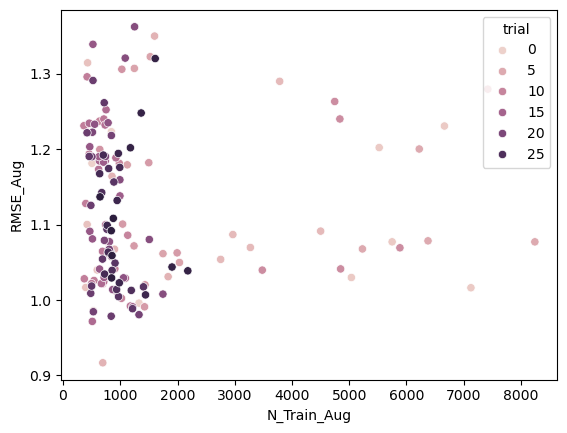

In [106]:
import seaborn as sns
sns.scatterplot(data=df_detailed, x="N_Train_Aug", y="RMSE_Aug", hue="trial")

In [107]:
df_detailed

,RMSE_NoAug,R2_NoAug,RMSE_Aug,R2_Aug,N_Train_NoAug,N_Train_Aug,N_Test,trial,max_heavy,max_ratio,min_common,pearson_thresh,crmsd_thresh,std_threshold
0,1.356907,0.585604,1.223191,0.663253,374,844,84,0,17,0.404398,4,0.577710,2.362008,2.637509
1,1.116801,0.731039,1.069395,0.753388,359,807,99,0,17,0.404398,4,0.577710,2.362008,2.637509
2,1.021401,0.786607,0.985864,0.801197,371,529,87,0,17,0.404398,4,0.577710,2.362008,2.637509
3,0.988616,0.793343,0.995930,0.790274,363,1327,95,0,17,0.404398,4,0.577710,2.362008,2.637509
4,1.213562,0.564423,1.181235,0.587320,365,505,93,0,17,0.404398,4,0.577710,2.362008,2.637509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1.368602,0.578430,1.108287,0.723548,374,878,84,29,16,0.424989,3,0.532621,2.187881,0.350169
146,1.099619,0.739251,1.091926,0.742887,359,842,99,29,16,0.424989,3,0.532621,2.187881,0.350169
147,1.019094,0.787569,1.058943,0.770631,371,855,87,29,16,0.424989,3,0.532621,2.187881,0.350169
148,1.003085,0.787250,1.029344,0.775965,363,848,95,29,16,0.424989,3,0.532621,2.187881,0.350169


<Axes: xlabel='R2_NoAug', ylabel='RMSE_NoAug'>

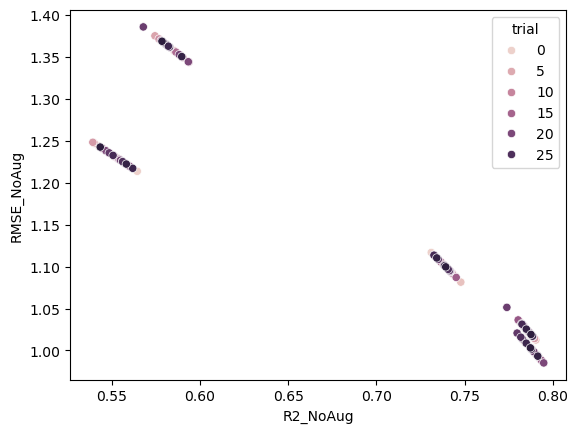

In [108]:
sns.scatterplot(data=df_detailed, x="R2_NoAug", y="RMSE_NoAug", hue="trial")

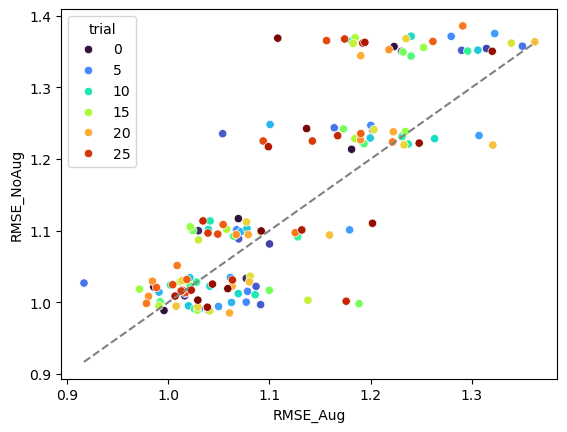

In [109]:
import matplotlib.pyplot as plt
sns.scatterplot(data=df_detailed, x="RMSE_Aug", y="RMSE_NoAug", hue="trial", palette="turbo")
plt.plot([df_detailed["RMSE_Aug"].min(), df_detailed["RMSE_Aug"].max()],
         [df_detailed["RMSE_Aug"].min(), df_detailed["RMSE_Aug"].max()],
         linestyle="--", color="gray")

In [110]:
import seaborn as sns
sns.scatterplot(data=df_detailed, x="N_Train_Aug", y="delta_RMSE", hue="trial")

ValueError: Could not interpret value `delta_RMSE` for `y`. An entry with this name does not appear in `data`.

<Axes: xlabel='RMSE_Aug', ylabel='delta_RMSE'>

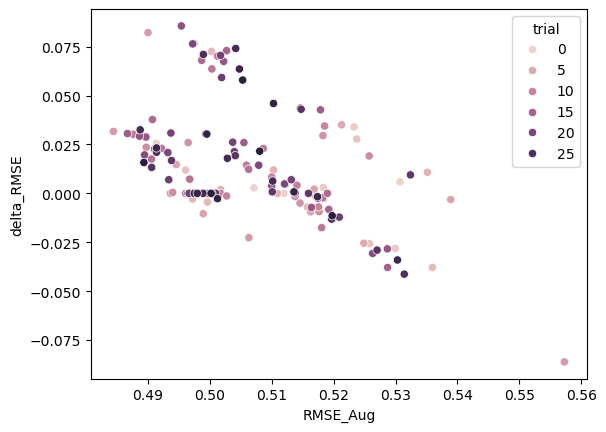

In [ ]:
import seaborn as sns
sns.scatterplot(data=df_detailed, x="RMSE_Aug", y="delta_RMSE", hue="trial")

In [ ]:
df_detailed["delta_RMSE"] = (df_detailed["RMSE_NoAug"] - df_detailed["RMSE_Aug"])/df_detailed["RMSE_NoAug"]
df_detailed["delta_R2"] = (df_detailed["R2_NoAug"] - df_detailed["R2_Aug"])/df_detailed["R2_NoAug"]

<Axes: xlabel='R2_Aug', ylabel='delta_R2'>

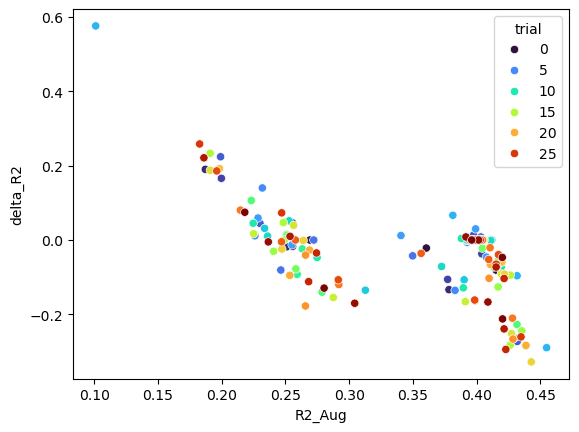

In [ ]:
sns.scatterplot(data=df_detailed, x="R2_Aug", y="delta_R2", hue="trial", palette="turbo")


In [ ]:
df_detailed.sort_values("R2_Aug", ascending=False).head(10)

,RMSE_NoAug,R2_NoAug,RMSE_Aug,R2_Aug,N_Train_NoAug,N_Train_Aug,N_Test,trial,max_heavy,max_ratio,min_common,pearson_thresh,crmsd_thresh,std_threshold,delta_RMSE,delta_R2
35,0.533898,0.352808,0.490007,0.454845,441,870,99,7,17,0.170476,3,0.468429,2.798059,1.422102,0.082210,-0.289214
90,0.541783,0.333550,0.495394,0.442793,441,730,99,18,16,0.227494,5,0.176666,1.817662,2.857975,0.085624,-0.327515
100,0.538391,0.341869,0.497231,0.438652,441,730,99,20,16,0.206332,5,0.181122,2.562892,2.994784,0.076451,-0.283099
65,0.538674,0.341177,0.497402,0.438265,441,800,99,13,16,0.113063,4,0.246831,0.370464,0.328020,0.076618,-0.284569
70,0.535070,0.349965,0.498681,0.435374,441,724,99,14,16,0.101616,4,0.234469,0.324783,2.193446,0.068008,-0.244048
125,0.537113,0.344992,0.498952,0.434758,441,825,99,25,15,0.193226,4,0.134408,2.430016,2.778893,0.071047,-0.260199
15,0.539422,0.339346,0.500253,0.431807,441,904,99,3,13,0.331695,2,0.150840,0.924355,0.436668,0.072613,-0.272469
38,0.500287,0.393861,0.484432,0.431673,429,714,111,7,17,0.170476,3,0.468429,2.798059,1.422102,0.031693,-0.096002
60,0.534331,0.351757,0.500332,0.431627,441,765,99,12,17,0.176051,5,0.125000,0.383681,0.392639,0.063629,-0.227058
55,0.539068,0.340213,0.501230,0.429586,441,731,99,11,16,0.100937,5,0.110471,0.363844,0.301149,0.070192,-0.262697


<Axes: xlabel='R2_NoAug', ylabel='R2_Aug'>

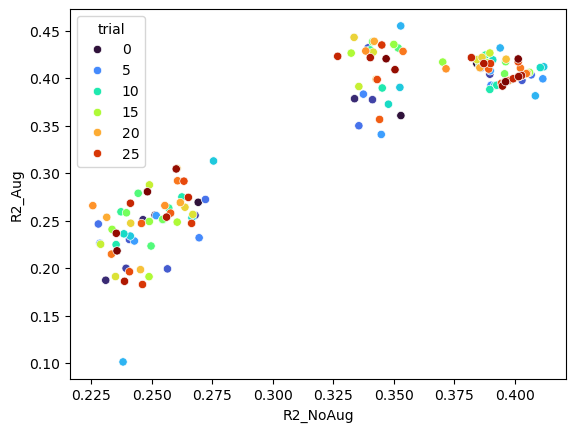

In [ ]:
sns.scatterplot(data=df_detailed, x="R2_NoAug", y="R2_Aug", hue="trial", palette="turbo")


In [ ]:
max heavy 17
min common 3
pearson 0.5
crmsd 2 
std 2

In [ ]:
df_summary.sort_values("r2_mean", ascending=False).head(10)

In [ ]:
1

In [130]:
# Save results
df_summary2 = pd.DataFrame([{k: v for k, v in r.items() if k != "all_fold_metrics"} for r in optimization_results])
df_summary2.to_csv("optuna_summary.csv", index=False)

# Save detailed metrics per trial
all_details = []
for i, res in enumerate(optimization_results):
    for fold_metric in res["all_fold_metrics"]:
        fold_metric.update({"trial": i})
        fold_metric.update(res["params"])
        all_details.append(fold_metric)

df_detailed2 = pd.DataFrame(all_details)
df_detailed2.to_csv("optuna_all_fold_metrics.csv", index=False)

print(df_summary2.sort_values("r2_mean", ascending=False))

                                              params   r2_mean    r2_std  \
2  {'max_heavy': 19, 'max_ratio': 0.3595487226525...  0.706386  0.053706   
3  {'max_heavy': 19, 'max_ratio': 0.3762403485114...  0.698738  0.043952   
5  {'max_heavy': 18, 'max_ratio': 0.3119170322436...  0.695872  0.050076   
0  {'max_heavy': 13, 'max_ratio': 0.2069413651976...  0.692097  0.052291   
4  {'max_heavy': 11, 'max_ratio': 0.1091399879235...  0.688818  0.053395   
1  {'max_heavy': 12, 'max_ratio': 0.1733420154323...  0.683010  0.049661   

   size_aug_mean  size_aug_std  size_noaug_mean  size_noaug_std  
2         4988.7    167.584635           1791.9         9.74115  
3         3416.6    187.804260           1791.9         9.74115  
5         2246.6     80.976787           1791.9         9.74115  
0         2153.7     71.188552           1791.9         9.74115  
4         2108.1     63.138657           1791.9         9.74115  
1         1901.7     38.670531           1791.9         9.74115  


<Axes: xlabel='N_Train_Aug', ylabel='RMSE_Aug'>

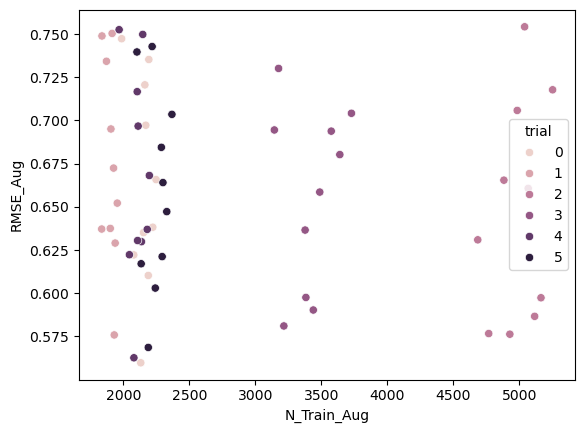

In [131]:
import seaborn as sns
sns.scatterplot(data=df_detailed2, x="N_Train_Aug", y="RMSE_Aug", hue="trial")

In [132]:
df_detailed2

,RMSE_NoAug,R2_NoAug,RMSE_Aug,R2_Aug,N_Train_NoAug,N_Train_Aug,N_Test,trial,max_heavy,max_ratio,min_common,pearson_thresh,crmsd_thresh,std_threshold
0,0.631466,0.719339,0.622185,0.727528,1773,2079,218,0,13,0.206941,4,0.328110,1.775376,2.062805
1,0.732368,0.632329,0.747284,0.617200,1789,1987,202,0,13,0.206941,4,0.328110,1.775376,2.062805
2,0.630572,0.704196,0.610290,0.722919,1792,2189,199,0,13,0.206941,4,0.328110,1.775376,2.062805
3,0.659065,0.740916,0.665761,0.735624,1808,2248,183,0,13,0.206941,4,0.328110,1.775376,2.062805
4,0.640597,0.742605,0.638205,0.744524,1803,2223,188,0,13,0.206941,4,0.328110,1.775376,2.062805
5,0.635837,0.699968,0.635108,0.700656,1785,2153,206,0,13,0.206941,4,0.328110,1.775376,2.062805
6,0.743617,0.626899,0.735259,0.635239,1802,2193,189,0,13,0.206941,4,0.328110,1.775376,2.062805
7,0.578580,0.745810,0.559766,0.762073,1793,2132,198,0,13,0.206941,4,0.328110,1.775376,2.062805
8,0.693748,0.622113,0.697219,0.618323,1788,2170,203,0,13,0.206941,4,0.328110,1.775376,2.062805
9,0.739380,0.638751,0.720588,0.656881,1786,2163,205,0,13,0.206941,4,0.328110,1.775376,2.062805


<Axes: xlabel='R2_NoAug', ylabel='RMSE_NoAug'>

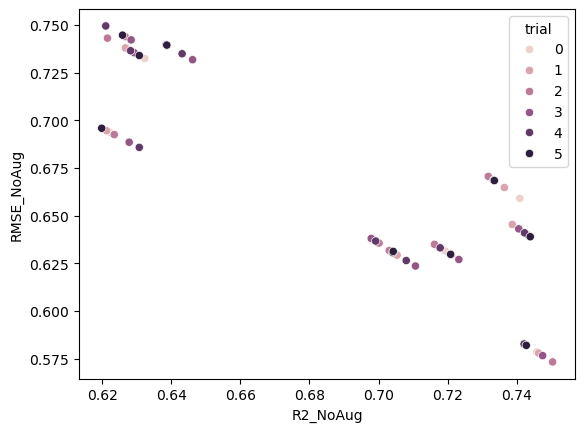

In [133]:
sns.scatterplot(data=df_detailed2, x="R2_NoAug", y="RMSE_NoAug", hue="trial")

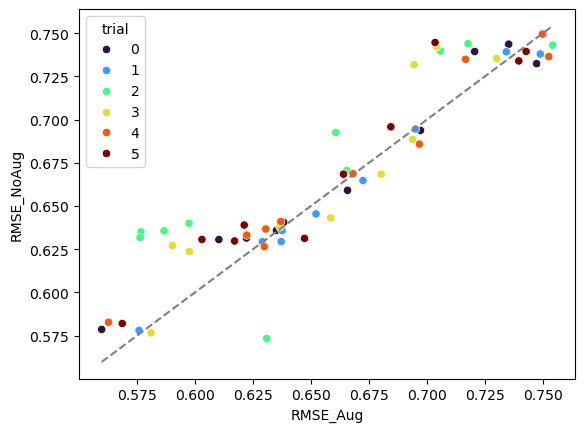

In [134]:
import matplotlib.pyplot as plt
sns.scatterplot(data=df_detailed2, x="RMSE_Aug", y="RMSE_NoAug", hue="trial", palette="turbo")
plt.plot([df_detailed2["RMSE_Aug"].min(), df_detailed2["RMSE_Aug"].max()],
         [df_detailed2["RMSE_Aug"].min(), df_detailed2["RMSE_Aug"].max()],
         linestyle="--", color="gray")

In [135]:
df_detailed2["delta_RMSE"] = (df_detailed2["RMSE_NoAug"] - df_detailed2["RMSE_Aug"])/df_detailed2["RMSE_NoAug"]
df_detailed2["delta_R2"] = (df_detailed2["R2_NoAug"] - df_detailed2["R2_Aug"])/df_detailed2["R2_NoAug"]

<Axes: xlabel='N_Train_Aug', ylabel='delta_RMSE'>

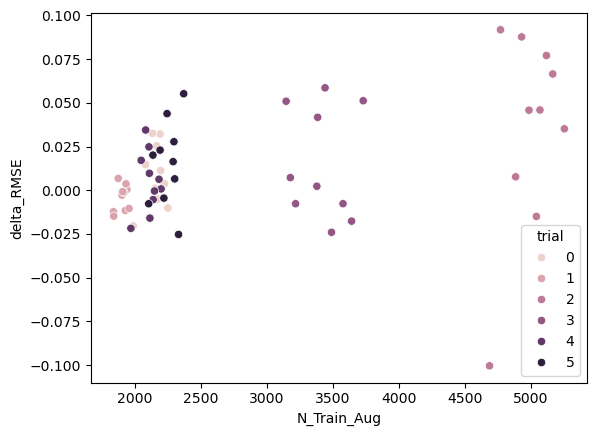

In [136]:
import seaborn as sns
sns.scatterplot(data=df_detailed2, x="N_Train_Aug", y="delta_RMSE", hue="trial")

<Axes: xlabel='RMSE_Aug', ylabel='delta_RMSE'>

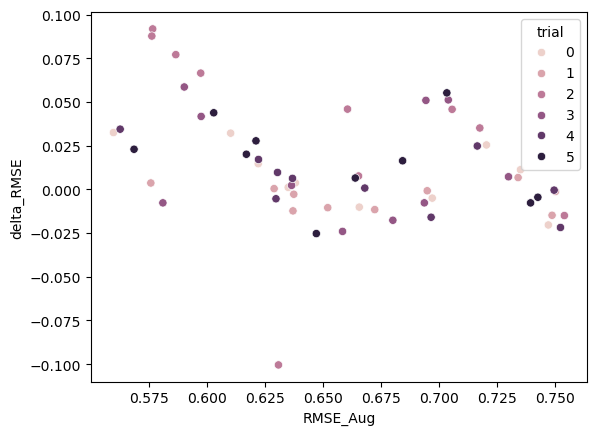

In [137]:
import seaborn as sns
sns.scatterplot(data=df_detailed2, x="RMSE_Aug", y="delta_RMSE", hue="trial")

<Axes: xlabel='R2_Aug', ylabel='delta_R2'>

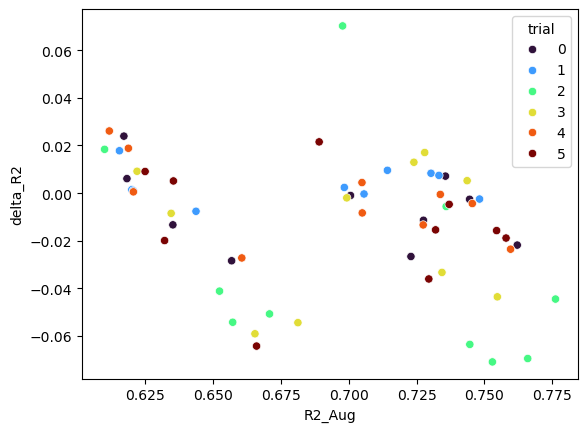

In [138]:
sns.scatterplot(data=df_detailed2, x="R2_Aug", y="delta_R2", hue="trial", palette="turbo")


In [139]:
df_detailed2.sort_values("R2_Aug", ascending=False).head(10)

,RMSE_NoAug,R2_NoAug,RMSE_Aug,R2_Aug,N_Train_NoAug,N_Train_Aug,N_Test,trial,max_heavy,max_ratio,min_common,pearson_thresh,crmsd_thresh,std_threshold,delta_RMSE,delta_R2
24,0.639959,0.743118,0.597391,0.776155,1803,5164,188,2,19,0.359549,3,0.288337,2.680390,2.989571,0.066517,-0.044458
20,0.634970,0.716216,0.576676,0.765930,1773,4768,218,2,19,0.359549,3,0.288337,2.680390,2.989571,0.091805,-0.069412
7,0.578580,0.745810,0.559766,0.762073,1793,2132,198,0,13,0.206941,4,0.328110,1.775376,2.062805,0.032518,-0.021806
47,0.582732,0.742149,0.562655,0.759610,1793,2080,198,4,11,0.109140,4,0.190817,2.110739,2.278976,0.034453,-0.023528
54,0.638949,0.743928,0.621211,0.757949,1803,2294,188,5,18,0.311917,5,0.229310,0.982448,0.447245,0.027762,-0.018847
30,0.627033,0.723265,0.590300,0.754740,1773,3439,218,3,19,0.376240,3,0.202058,0.429058,1.482210,0.058583,-0.043517
57,0.581999,0.742797,0.568640,0.754469,1793,2189,198,5,18,0.311917,5,0.229310,0.982448,0.447245,0.022954,-0.015713
22,0.631726,0.703112,0.576307,0.752918,1792,4928,199,2,19,0.359549,3,0.288337,2.680390,2.989571,0.087728,-0.070836
17,0.577986,0.746332,0.575875,0.748182,1793,1931,198,1,12,0.173342,5,0.566573,1.596664,1.335750,0.003653,-0.002479
44,0.640989,0.742290,0.636958,0.745521,1803,2181,188,4,11,0.109140,4,0.190817,2.110739,2.278976,0.006289,-0.004353


<Axes: xlabel='R2_NoAug', ylabel='R2_Aug'>

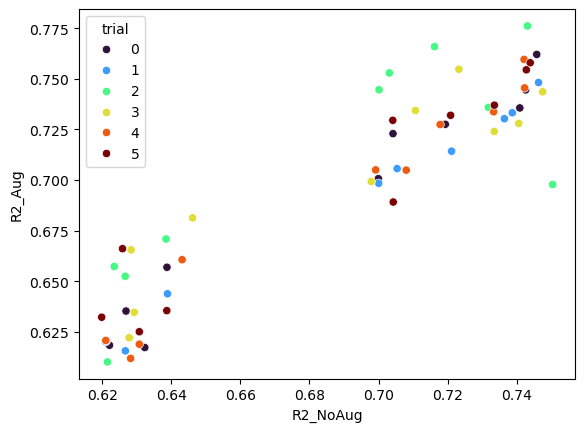

In [140]:
sns.scatterplot(data=df_detailed2
                , x="R2_NoAug", y="R2_Aug", hue="trial", palette="turbo")


In [ ]:
max heavy 15
max ratio .35
crmsd 0.8
std 1.9
min common 3
pearsonr 0,3

SyntaxError: invalid syntax (1142949444.py, line 1)

In [ ]:
1